In [1]:
#import nmresearch as nmr
import scipy as sp
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import qutip as qt
from qutip import hinton, identity, to_super, sigmaz, tensor, tensor_contract, sigmax, projection, jmat, basis, propagator, coefficient

In [2]:
Sz = tensor(jmat(1/2,'z'), identity([2]))
Sx = tensor(jmat(1/2,'x'),identity([2]))
Sy = tensor(jmat(1/2,'y'),identity([2]))

Iz = tensor(identity(2), jmat(1/2,'z'))
Ix = tensor(identity(2), jmat(1/2,'x'))
Iy = tensor(identity(2), jmat(1/2,'y'))

In [3]:
sqrt2 = np.sqrt(2)
isqrt2 = 1/np.sqrt(2)

GHz=1e3
MHz=1
kHz=1e-3

ms=1e3
us=1
ns=1e-3

T = 1e4
G = 1

B = 360

gamma_e = -28024 * MHz / T
gamma_p = 42.577 * MHz / T
gamma_N = -4.316 * MHz / T

omegaNV =  2.87 * GHz + gamma_e * B
omegaX = gamma_e * B
omegaN15 = gamma_N * B
omegaP = gamma_p * B

D = 60 * kHz
Omega = 1 * MHz

T1e = 1*ms
T2e = 4*us
T1n = 10*ms
T2n = 500*us

T1e_rho = 100*us # this is emergent, no need to add directly

t_swap_nvx = 7.95*us

deg = np.pi/180

In [5]:
omegaX

-1008.864

In [6]:
omegaP

1.5327719999999998

In [4]:
e0 = basis(2,0)
e1 = basis(2,1)
n0 = basis(2,0)
n1 = basis(2,1)

ket00 = tensor(e0,n0)
ket01 = tensor(e0,n1)
ket10 = tensor(e1,n0)
ket11 = tensor(e1,n1)

rho00 = tensor(projection(2,0,0), projection(2,0,0))
rho01 = tensor(projection(2,0,0), projection(2,1,1))
rho10 = tensor(projection(2,1,1), projection(2,0,0))
rho11 = tensor(projection(2,1,1), projection(2,1,1))

In [5]:
e_c_ops = [1/(2*T1e) * Sx, 1/(2*T1e) * Sy, 1/(2*T2e) * Sz]

n_c_ops = [1/(2*T1n) * Ix, 1/(2*T1n) * Iy, 1/(2*T2n) * Iz]

lindblad_ops = e_c_ops + n_c_ops 

In [6]:
def noise(t):
    # computes noise propegator for a time t while no 
    # other evolution is occuring
    return propagator(identity([2,2]), t, c_ops=lindblad_ops)

def partial_pol_state(pol):
    # returns a state partially polarize along Z
    # polarization must be a number between -1 and 1
    assert abs(pol) <= 1
    return (1+pol)/2*projection(2,0,0) + (1-pol)/2*projection(2,1,1)

def nv_reset(pol):
    return tensor(projection(2,0,0), partial_pol_state(pol), prho)

In [7]:
zdir_nv = (1/np.sqrt(3))*np.array([1,1,1])
theta_nv = np.arccos(1/np.sqrt(3))
phi_nv = 45*deg

def EulerMatrix(alpha, beta, gamma):
    return Rz(alpha) @ Ry(beta) @ Rz(gamma)

def Rz(alpha):
    return np.array(
        [
            [np.cos(alpha), -np.sin(alpha),0],
            [np.sin(alpha), np.cos(alpha),0],
            [0,0,1]
        ]
    )

def Ry(alpha):
    return np.array(
        [
            [np.cos(alpha), 0, np.sin(alpha)],
            [0,1, 0],
            [-np.sin(alpha),0, np.cos(alpha)]
        ]
    )

def Rx(alpha):
    return np.array(
        [
            [1,0,0],
            [0, np.cos(alpha), -np.sin(alpha),],
            [0, np.sin(alpha), np.cos(alpha),]
        ]
    )

In [8]:
# check that R properly rotates into the NV frame
R = EulerMatrix(phi_nv, theta_nv, 0)
(R.T @ zdir_nv) @ np.array([0,0,1])

1.0000000000000002

In [9]:
# magnetic field alignment in the lab frame
theta = 0
phi = phi_nv

# some other relative angles 
alpha = 0*deg
beta = 90*deg

# principle components of uni-axial symm HF tensor
A_perp = 17.2 * MHz
A_para = 29.4 * MHz

# direction of B field in the lab frame
Bdir = np.array([np.sin(theta)*np.sin(phi), np.sin(theta)*np.cos(phi), np.cos(theta)])

# Hyperfine tensor in the principle axis frame
A_principle = np.array([[A_perp, 0, 0], [0, A_perp, 0], [0, 0, A_para]])

RB = EulerMatrix(phi, theta, 0)
RA = EulerMatrix(beta, alpha, 0)

# NV-frame hyperfine tensor
A = RB @ RA.T @ A_principle @ RA @ RB.T

In [10]:
A

array([[1.72000000e+01, 2.13924533e-16, 0.00000000e+00],
       [2.13924533e-16, 1.72000000e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.94000000e+01]])

In [11]:
H = 2*pi*(omegaX * Sz + omegaP * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * Ix) + A[2,1] * (Sz * Iy))

H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-3118.44297361     0.             0.             0.        ]
 [    0.         -3220.43648813     0.             0.        ]
 [    0.             0.          3128.07366412     0.        ]
 [    0.             0.             0.          3210.80579762]]

In [12]:
energies = H.eigenenergies()

In [13]:
energies

array([-3220.43648813, -3118.44297361,  3128.07366412,  3210.80579762])

In [14]:
omega_bar = abs(omegaX + omegaP)
delta_omega = abs(omegaX - omegaP)

In [15]:
2*pi*(-omega_bar/2 + A[2,2]/4)

-3118.442973608615

In [16]:
-delta_omega/2 - A[2,2]/4

-512.548386

In [17]:
delta_omega/2 - A[2,2]/4

497.848386

In [18]:
omega_bar/2 + A[2,2]/4

511.015614

In [19]:
omega_cnot21_IDEAL = ((omega_bar/2 + A[2,2]/4) - (-delta_omega/2 - A[2,2]/4))
omega_cnot21_MEAS = (energies[3]-energies[0])/(2*pi)
omega_cnot12_IDEAL = ((omega_bar/2 + A[2,2]/4) - (delta_omega/2 - A[2,2]/4))
omega_cnot12_MEAS = (energies[3]-energies[2])/(2*pi)

In [20]:
energies[3]-energies[2]

82.73213350588367

In [21]:
omega_cnot12_MEAS

13.167228000000003

In [22]:
omega_cnot12_IDEAL

13.167228000000023

In [23]:
energies[3]-energies[0]

6431.242285757966

In [24]:
omega_cnot21_MEAS

1023.564

In [25]:
rho0 = 0.5*tensor(projection(2,0,0), identity([2]))

In [26]:
HrE = 2*pi* ((omegaX + omega_cnot21_MEAS) * Sz + omegaP * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * Ix) + A[2,1] * (Sz * Iy) + 1.4*MHz*Sx)

HrE

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 97.17816927   0.           4.39822972   0.        ]
 [  0.          -4.81534525   0.           4.39822972]
 [  4.39822972   0.         -87.54747876   0.        ]
 [  0.           4.39822972   0.          -4.81534525]]

In [27]:
times = np.arange(0,1,.005)


resE = qt.mesolve(HrE,rho01,times,c_ops=lindblad_ops)
signal = [qt.expect(rho11, state) for state in resE.states]
#signal = [ abs(ket11.trans() * (-1j * t * HrE).expm() * ket01)**2 for t in times]
#signal_other = [ abs(ket10.trans() * (-1j * t * HrE).expm() * ket00)**2 for t in times]
t_cnot_e = times[np.argmax(signal)]

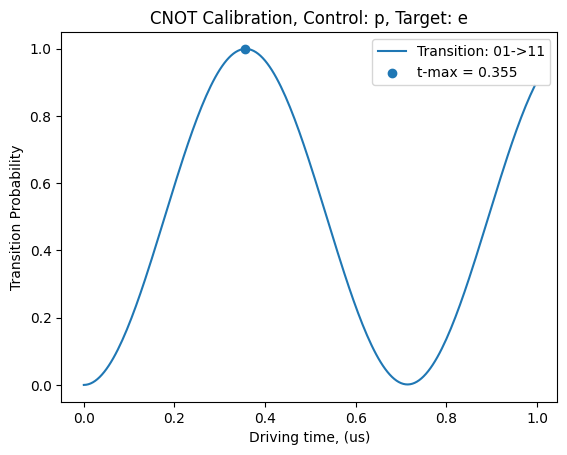

In [28]:
plt.plot(times,signal,label="Transition: 01->11")
#plt.plot(times,signal_other,label="Leakage")
plt.scatter(t_cnot_e, np.max(signal),label=f"t-max = {t_cnot_e}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [29]:
3/(1.4*MHz)

2.142857142857143

In [30]:
cnot_e = propagator(HrE, t_cnot_e, c_ops=lindblad_ops)

In [31]:
qt.unitarity(cnot_e)

0.9969487199555616

In [33]:
cost = coefficient(lambda t: np.cos(omega_cnot12_MEAS*t))
sint = coefficient(lambda t: np.sin(omega_cnot12_MEAS*t))

In [34]:
# this is a time dependent hamiltonian with slow terms that might matter

HrN =  (omegaP+omega_cnot12_MEAS) * Iz + A[2,2] * (Sz * Iz) + A[2,0] * (Sz * (cost*Ix + sint*Iy)) + A[2,1] * (Sz * (cost*Iy - sint*Ix)) + 40 * kHz*Ix

HrN

QobjEvo: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, superrep = None, isconstant = False, num_elements = 6

In [35]:
times = np.arange(0,1/(40*kHz),.1)
res = qt.mesolve(2*np.pi*HrN, rho10, times, c_ops=lindblad_ops)
res_leak = qt.mesolve(2*np.pi*HrN, rho00, times, c_ops=lindblad_ops)

In [36]:
nuc_signal = [qt.expect(rho11, state) for state in res.states]
nuc_signal_other = [qt.expect(rho01, state) for state in res_leak.states]

In [37]:
#nuc_signal = [ abs(ket11.trans() * (-1j * t * HrN).expm() * ket10)**2 for t in times]
#nuc_signal_other = [ abs(ket01.trans() * (-1j * t * HrN).expm() * ket00)**2 for t in times]
t_cnot_nuc = times[np.argmax(nuc_signal)]

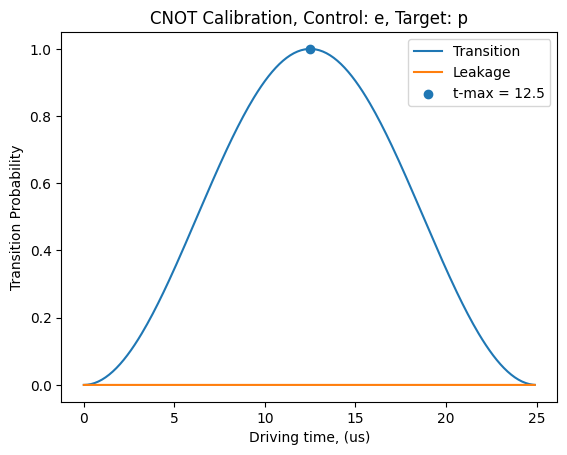

In [38]:
plt.plot(times,nuc_signal,label="Transition")
plt.plot(times,nuc_signal_other,label="Leakage")
plt.scatter(t_cnot_nuc, np.max(nuc_signal),label=f"t-max = {t_cnot_nuc}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: e, Target: p")
plt.legend()
plt.show()

In [39]:
np.max(nuc_signal)

0.9997741783808988

In [40]:
t_cnot_nuc

12.5

In [58]:
cnot_n = propagator(2*np.pi*HrN, t_cnot_nuc, c_ops=lindblad_ops,options={'nsteps':1e7})

In [59]:
qt.unitarity(cnot_n)

0.8778730013070205

In [60]:
qt.gates.cnot()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [61]:
swap = cnot_e*cnot_n*cnot_e

In [62]:
qt.unitarity(swap)

0.8726889272143858

In [63]:
rho10

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [64]:
rho01

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [65]:
qt.vector_to_operator(swap * qt.operator_to_vector(rho01))

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.20352558e-03-2.54259357e-21j  3.63533321e-06-9.90803129e-07j
  -4.61911623e-02-7.47497836e-03j  1.10924377e-04+3.84040324e-04j]
 [ 3.63533321e-06+9.90803129e-07j  2.19285650e-06+3.53348811e-19j
  -6.56761930e-05-3.08983474e-05j -9.15392244e-09+7.49247787e-06j]
 [-4.61911623e-02+7.47497836e-03j -6.56761930e-05+3.08983474e-05j
   9.97008327e-01+2.98900839e-21j -3.61817167e-03-7.69316911e-03j]
 [ 1.10924377e-04-3.84040324e-04j -9.15392240e-09-7.49247787e-06j
  -3.61817167e-03+7.69316911e-03j  7.85954342e-04-3.53348227e-19j]]